# Dependencies

In [5]:
import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [6]:
from scripts.constants import RANDOM_SEED
from scripts.utils import get_dataset_by_name, z_score_norm, resample_features, extract_zip_file

# Setup

In [7]:
import logging
logging.basicConfig(level=logging.INFO)

In [8]:
data_dir = os.path.join('..', 'data')

# Data Preperation

In [9]:
# Unzipping dataset contents if not yet done
extract_zip_file()

INFO:scripts.utils:Files already unzipped


In [10]:
np_rest_105923 = get_dataset_by_name(dataset_name='rest_105923', dataset_dir=os.path.join(data_dir, 'intra', 'train'))

INFO:scripts.utils:Processing dataset ..\data\intra\train\rest_105923
INFO:scripts.utils:6 files found: ['rest_105923_1.h5', 'rest_105923_2.h5', 'rest_105923_4.h5', 'rest_105923_5.h5', 'rest_105923_7.h5', 'rest_105923_8.h5']
100%|██████████| 6/6 [00:00<00:00,  9.01it/s]
INFO:scripts.utils:Retrieved shapes:  [(248, 35624), (248, 35624), (248, 35624), (248, 35624), (248, 35624), (248, 35624)]
INFO:scripts.utils:Resulting shape:  (248, 213744)


# Exploratory plots

In [11]:
np_rest_105923_norm = z_score_norm(np_rest_105923)

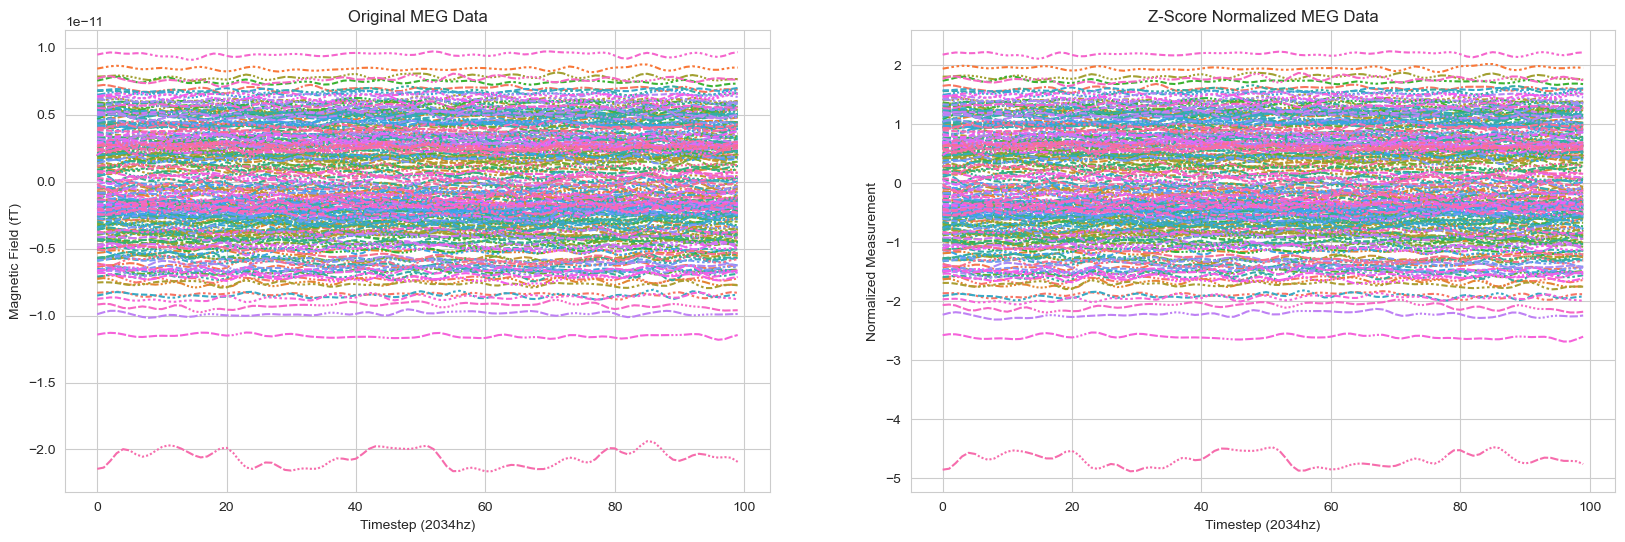

In [12]:
# First 100 time steps of the 248 features.
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs[0] = sns.lineplot(data=np_rest_105923[:, :100].T, ax=axs[0])
axs[0].get_legend().remove()
axs[0].set_title('Original MEG Data')
axs[0].set_ylabel('Magnetic Field (fT)')
axs[0].set_xlabel('Timestep (2034hz)')

axs[1] = sns.lineplot(data=np_rest_105923_norm[:, :100].T, ax=axs[1])
axs[1].get_legend().remove()
axs[1].set_title('Z-Score Normalized MEG Data')
axs[1].set_ylabel('Normalized Measurement')
axs[1].set_xlabel('Timestep (2034hz)')

plt.show()

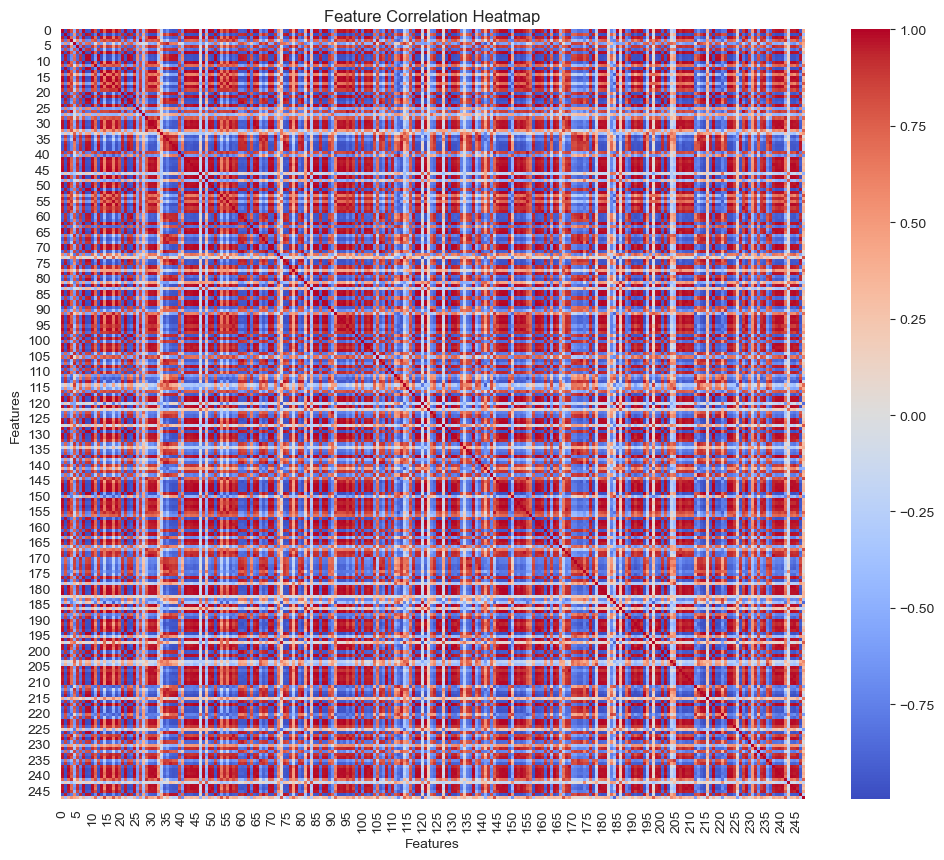

In [13]:
correlations_test = np.corrcoef(np_rest_105923)

plt.figure(figsize=(12, 10))
sns.heatmap(correlations_test, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [14]:
# TODO: a hyperparameter to tune up most likely
downsampling_factor = 2034 // 50  # 100 samples per second
logging.info(f'Downsampling factor: {downsampling_factor}')
np_rest_105923_downsampled = resample_features(np_rest_105923_norm, downsampling_factor)

INFO:root:Downsampling factor: 40
INFO:scripts.utils:Shape change (248, 213744) -> (248, 5343)


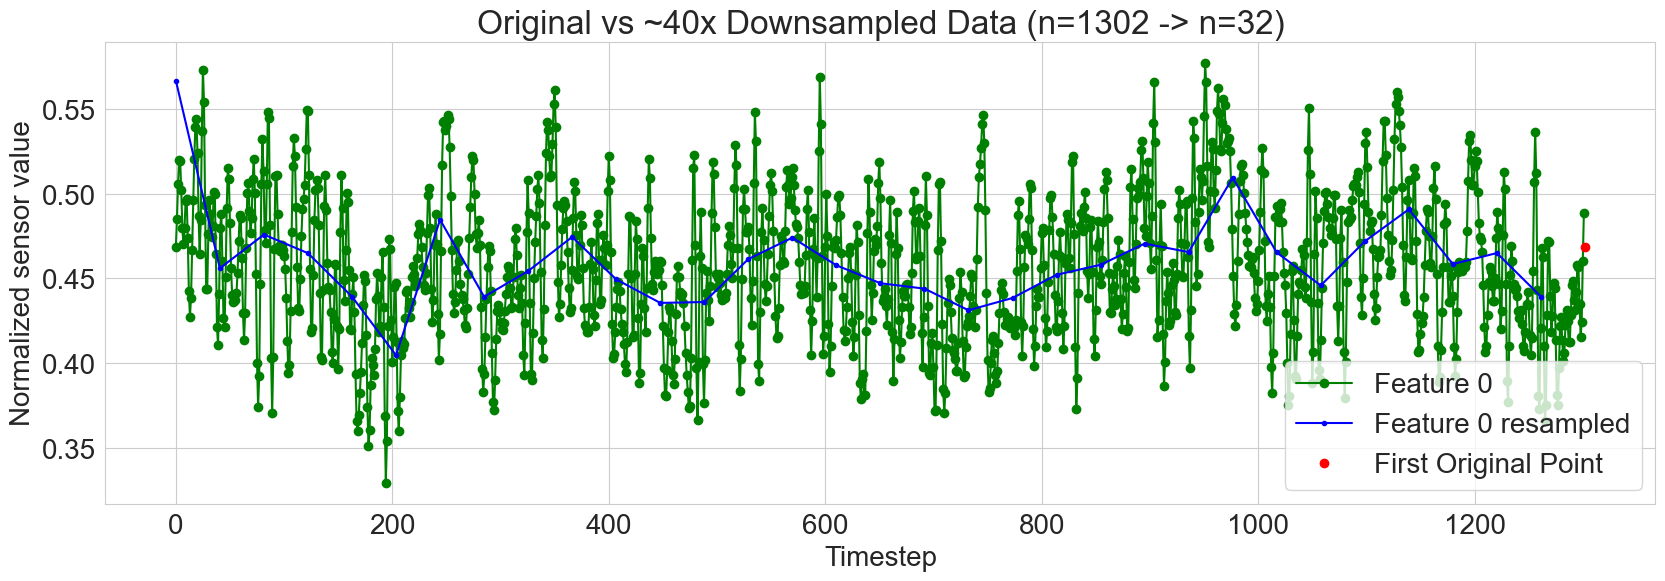

In [23]:
plt.rcParams.update({'font.size': 20})

num_timesteps_sample = round(0.64*2034)

full_data_sample = np_rest_105923_norm[0, :num_timesteps_sample]
downsampled_data_sample = np_rest_105923_downsampled[0, :num_timesteps_sample // downsampling_factor]

x = np.arange(0, num_timesteps_sample, 1)
xnew = np.linspace(0, num_timesteps_sample, len(downsampled_data_sample), endpoint=False)

plt.figure(figsize=(20, 6))
plt.plot(x, full_data_sample, 'go-', label='Feature 0')
plt.plot(xnew, downsampled_data_sample, 'b.-', label='Feature 0 resampled')
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html
# 'Note that the end of the resampled data rises to meet the first sample of the next cycle'
plt.plot(num_timesteps_sample, full_data_sample[0], 'ro', label='First Original Point') 
plt.legend(loc='best')
plt.title(f"Original vs ~{downsampling_factor}x Downsampled Data (n={num_timesteps_sample} -> n={32})")
plt.xlabel("Timestep")
plt.ylabel("Normalized sensor value")
plt.grid(True)
plt.show()